# Installation des packages

# Préparation des données

In [33]:
from scripts import data_collector as dc
from scripts import data_cleaner as dcl
from scripts import data_analysis as da
from scripts import data_visualization as dv
import pandas as pd

landlocked_url = "https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline"
codesISO_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

# Codes ISO-2 et ISO-3 relatifs aux pays

In [34]:
try:
    codesISO_data = dc.get_ISOcodes(codesISO_url)
    codesISO_data = dcl.clean_ISOData(codesISO_data)
except Exception as e:
    print(f"An error occurred while fetching or cleaning ISO codes data: {e}")
    codesISO_data = pd.read_csv("data/ISO_data.csv")
    codesISO_data.drop(columns=['Unnamed: 0'], inplace=True)
    
codesISO_data

,Pays,ISO-2,ISO-3
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,Andorra,AD,AND
4,Angola,AO,AGO
...,...,...,...
188,Venezuela (Bolivarian Republic of),VE,VEN
189,Viet Nam[ak],VN,VNM
190,Yemen,YE,YEM
191,Zambia,ZM,ZMB


# PIB Réel

L'API permet de récupérer des données sur les pays via leurs codes ISO avec 2 lettres
Exemple : "FR" pour la France, "DE" pour l'Allemagne, "GB" pour le Royaume-Uni, etc.

In [35]:
wb = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
PIB_Reel_data = wb.get_indicator("PIB", liste_pays, start=1990, end=2024)
PIB_Reel_data

,country,date,PIB
0,Afghanistan,2024,NaN
1,Afghanistan,2023,1.567265e+10
2,Afghanistan,2022,1.532523e+10
3,Afghanistan,2021,1.634520e+10
4,Afghanistan,2020,2.062196e+10
...,...,...,...
6750,Zimbabwe,1994,1.775729e+10
6751,Zimbabwe,1993,1.625602e+10
6752,Zimbabwe,1992,1.608687e+10
6753,Zimbabwe,1991,1.768090e+10


Il y a des problèmes avec les correspondances de noms entre les codes ISO et les noms des pays dans le dataframe PIB_reel_data
# Faire correspondre les noms des pays à la liste des ISO

In [36]:
PIB_countries = set(PIB_Reel_data["country"].unique())
ISO_countries = set(codesISO_data["Pays"].unique())

matching_dictionnary = {}

# Récupérer les pays avec un seul mot dans leur nom
single_word_countries = set(PIB_Reel_data[PIB_Reel_data['country'].str.split().str.len() == 1]['country'].tolist())
ISO_complicated_word_countries = ISO_countries 
potential_matching_complicated_word_countries = PIB_countries 

# Premier algorithme de matching basé sur les pays où les noms n'ont pas des caractères bizarres mais juste plusieurs mots
solved_ISO_complicated_word_countries = set()
solved_potential_matching_word_countries = set()

for iso_country in ISO_complicated_word_countries:
    for pib_country in potential_matching_complicated_word_countries:
        if iso_country in pib_country or pib_country in iso_country:
            matching_dictionnary[pib_country] = iso_country
            solved_ISO_complicated_word_countries.add(iso_country)
            solved_potential_matching_word_countries.add(pib_country)
            

# Afficher les pays non résolus après le premier algorithme
unresolved_ISO_countries = ISO_complicated_word_countries - solved_ISO_complicated_word_countries
unresolved_potential_matching_countries = potential_matching_complicated_word_countries - solved_potential_matching_word_countries

# Résoudre les derniers problèmes

for pib_country in unresolved_potential_matching_countries:
    for iso_country in unresolved_ISO_countries:
        # Je n'ai pas besoin des caractères après la virgule pour les pays problématiques.
        pib_country = pib_country.split(',')[0]
        
        if pib_country[:5] == iso_country[:5]:
            matching_dictionnary[pib_country] = iso_country
            break
        
# Résoudre les problèmes d'autres pays déviants manuellement
          
matching_dictionnary['Congo, Dem. Rep.'] = 'Congo (the Democratic Republic of the)'
matching_dictionnary['Congo, Rep.'] = 'Congo (the)[k]'
matching_dictionnary['Turkiye'] = 'Türkiye[ag]'
matching_dictionnary['Korea, Rep.'] = 'Korea (the Republic of)[u]'
matching_dictionnary['Korea, Dem. People\'s Rep.'] = 'Korea (the Democratic People\'s Republic of)[t]'
matching_dictionnary['Venezuela, RB'] = 'Venezuela (Bolivarian Republic of)'

In [37]:
# Matcher maintenant les pays aux ISO

ISO_matching_dictionnary = {}
for i in range(len(codesISO_data)):
    line = codesISO_data.iloc[i]
    ISO_matching_dictionnary[line["Pays"]] = line["ISO-3"]
    
ISO_matching_dictionnary

for key in matching_dictionnary.keys():
    matching_dictionnary[key] = ISO_matching_dictionnary[matching_dictionnary[key]]
    
matching_dictionnary

{'Kazakhstan': 'KAZ',
 'Paraguay': 'PRY',
 'Belize': 'BLZ',
 'Austria': 'AUT',
 'Mali': 'MLI',
 'Iraq': 'IRQ',
 'Cuba': 'CUB',
 'Namibia': 'NAM',
 'Barbados': 'BRB',
 'Panama': 'PAN',
 'Cambodia': 'KHM',
 'Costa Rica': 'CRI',
 'South Africa': 'ZAF',
 'Mauritania': 'MRT',
 'Latvia': 'LVA',
 'Italy': 'ITA',
 'Bosnia and Herzegovina': 'BIH',
 'Japan': 'JPN',
 'Mozambique': 'MOZ',
 'Montenegro': 'MNE',
 'Zambia': 'ZMB',
 'Belgium': 'BEL',
 'Tunisia': 'TUN',
 'Moldova': 'MDA',
 'Indonesia': 'IDN',
 'Luxembourg': 'LUX',
 'Marshall Islands': 'MHL',
 'Trinidad and Tobago': 'TTO',
 'Cyprus': 'CYP',
 'Lesotho': 'LSO',
 'Eritrea': 'ERI',
 'Vanuatu': 'VUT',
 'Yemen, Rep.': 'YEM',
 'China': 'CHN',
 'Ecuador': 'ECU',
 'Mauritius': 'MUS',
 'Bangladesh': 'BGD',
 'Egypt, Arab Rep.': 'EGY',
 'Eswatini': 'SWZ',
 'Qatar': 'QAT',
 'Slovenia': 'SVN',
 'Rwanda': 'RWA',
 'Comoros': 'COM',
 'San Marino': 'SMR',
 'Algeria': 'DZA',
 'Equatorial Guinea': 'GIN',
 'Guinea': 'GIN',
 'Azerbaijan': 'AZE',
 'Benin': 'B

In [38]:
PIB_Reel_data["country"] = PIB_Reel_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
PIB_Reel_data


,country,date,PIB
0,AFG,2024,NaN
1,AFG,2023,1.567265e+10
2,AFG,2022,1.532523e+10
3,AFG,2021,1.634520e+10
4,AFG,2020,2.062196e+10
...,...,...,...
6750,ZWE,1994,1.775729e+10
6751,ZWE,1993,1.625602e+10
6752,ZWE,1992,1.608687e+10
6753,ZWE,1991,1.768090e+10


# Valeurs manquantes

In [39]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

Le dataframe contient des données temporelles relatives à 188 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.


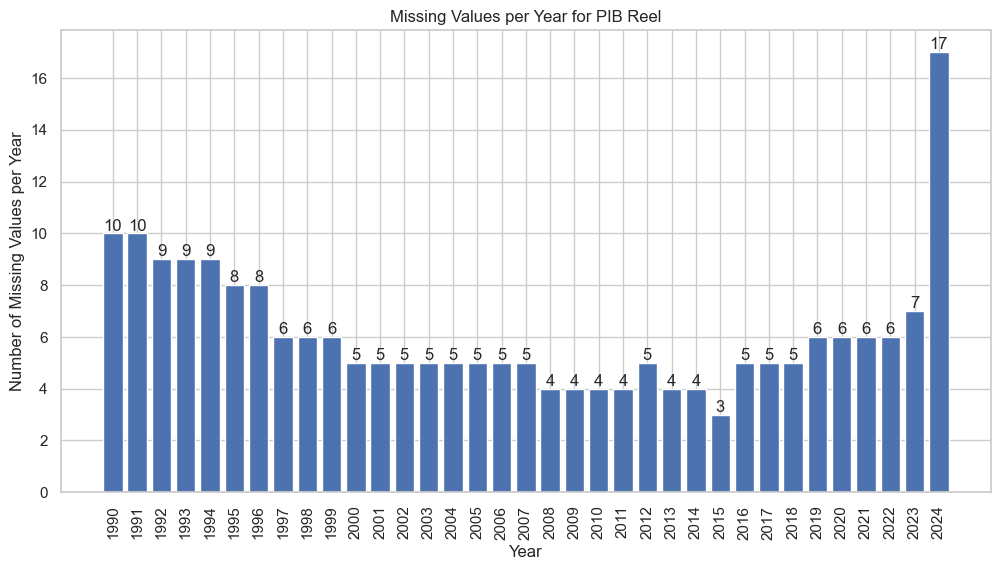

In [40]:
# Là on va checker d'où viennent les valeurs manquantes

# On va d'abord faire une analyse par date pour voir si c'est ça qui cause le problème

dv.plot_missing_values_per_year(PIB_Reel_data,"PIB")

In [41]:
# C'est bizarre qu'en 2024 il y ait plus de valeurs manquantes en 2024. Vérifions les pays dont les valeurs sont manquantes en 2024
NaN2024 = PIB_Reel_data[PIB_Reel_data["date"]==2024]["PIB"].isna()
NaN2024_countries = PIB_Reel_data[PIB_Reel_data["date"]==2024][NaN2024]
NaN2024_countries

# faire un commentaire
# Ce qu'on peut probablement faire c'est de l'imputation de données manquantes en utilisant la moyenne des valeurs des années précédentes pour chaque pays.
# Mais cela ne peut se faire que si on est dans des années qui sont intérieures c'est-à dire à partir de la première année omù il n'y a pas de valeur manquante

,country,date,PIB
0,AFG,2024,NaN
910,BTN,2024,NaN
1435,CUB,2024,NaN
1820,ERI,2024,NaN
3255,KOR,2024,NaN
3360,LBN,2024,NaN
3500,LIE,2024,NaN
3745,MCO,2024,NaN
4830,PLW,2024,NaN
4935,PRK,2024,NaN


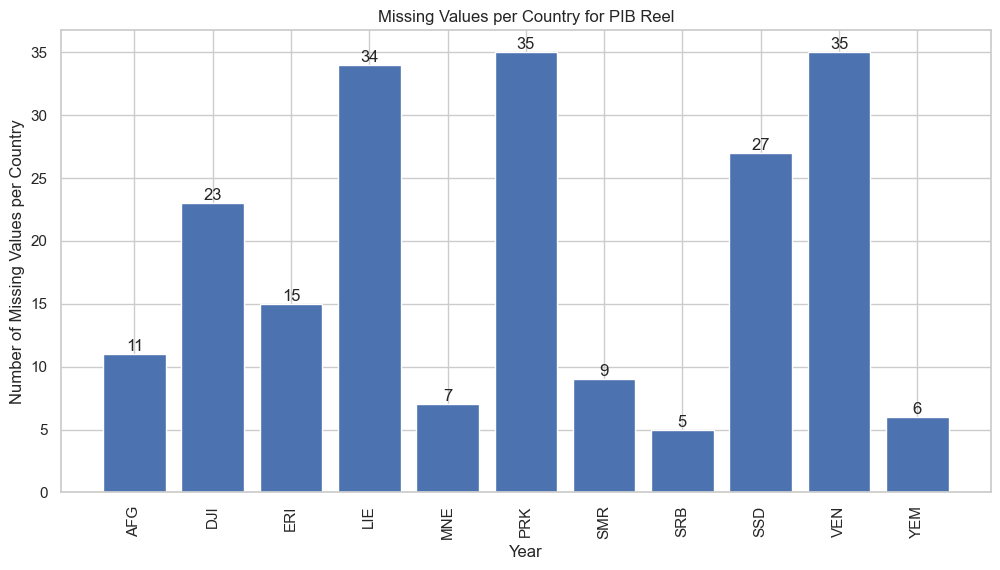

In [42]:
# Missing data per countries
# On va mettre un treshold à 5 valeurs pour tolérer 10% de données manquantes sinon on vire le pays.
countries_toRemove = dv.plot_missing_values_per_country(PIB_Reel_data,"PIB",treshold=0.1)

indexes_toRemove = []
for country in countries_toRemove:
    country_indexes = PIB_Reel_data[PIB_Reel_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

In [43]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

PIB_Reel_data_cleaned = PIB_Reel_data.drop(indexes_toRemove,axis='index')
PIB_Reel_data_cleaned.reset_index(drop=True,inplace=True)
da.check_missing_values(PIB_Reel_data_cleaned,"PIB")

Le dataframe contient des données temporelles relatives à 188 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 177 pays de 1990 à 2024.
Il y a 9 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.14% de valeurs manquantes dans la base de données.


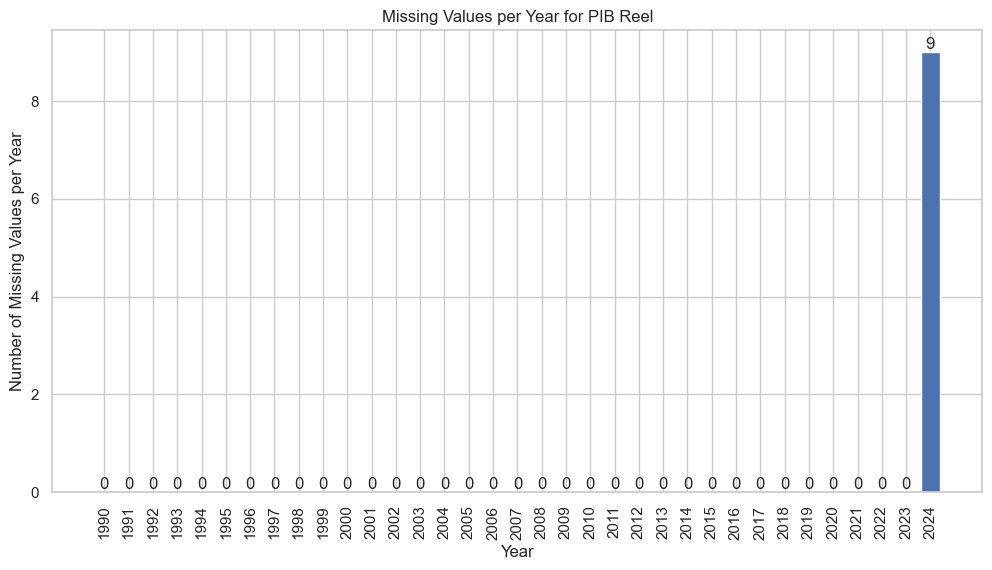

In [44]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(PIB_Reel_data_cleaned,"PIB")

In [45]:
# La majeure partie des valeurs manquantes sont en 2024. On peut les imputer avec la moyenne des années précédentes.
PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
da.check_missing_values(PIB_Reel_data_final,"PIB")
PIB_Reel_data_final

Le dataframe contient des données temporelles relatives à 177 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.00% de valeurs manquantes dans la base de données.


,country,date,PIB
0,AGO,2024,8.959422e+10
1,AGO,2023,8.579857e+10
2,AGO,2022,8.488345e+10
3,AGO,2021,8.237534e+10
4,AGO,2020,8.139919e+10
...,...,...,...
6365,ZWE,1994,1.775729e+10
6366,ZWE,1993,1.625602e+10
6367,ZWE,1992,1.608687e+10
6368,ZWE,1991,1.768090e+10


## Description du PIB

## Evolution du PIB mondial

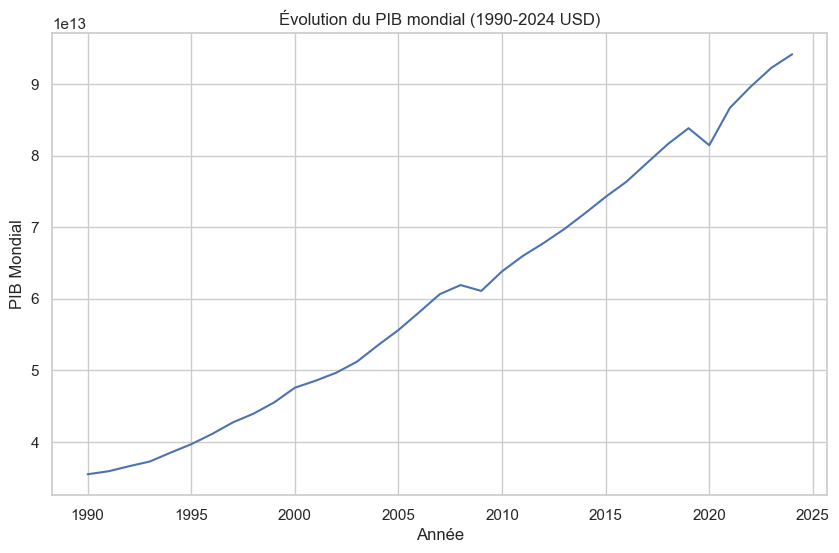

In [46]:
## Description du PIB
import matplotlib.pyplot as plt
dv.plot_world_PIB(PIB_Reel_data_final)

# Faire un commentaire

# Analyse des PIB de pays par quartiles 

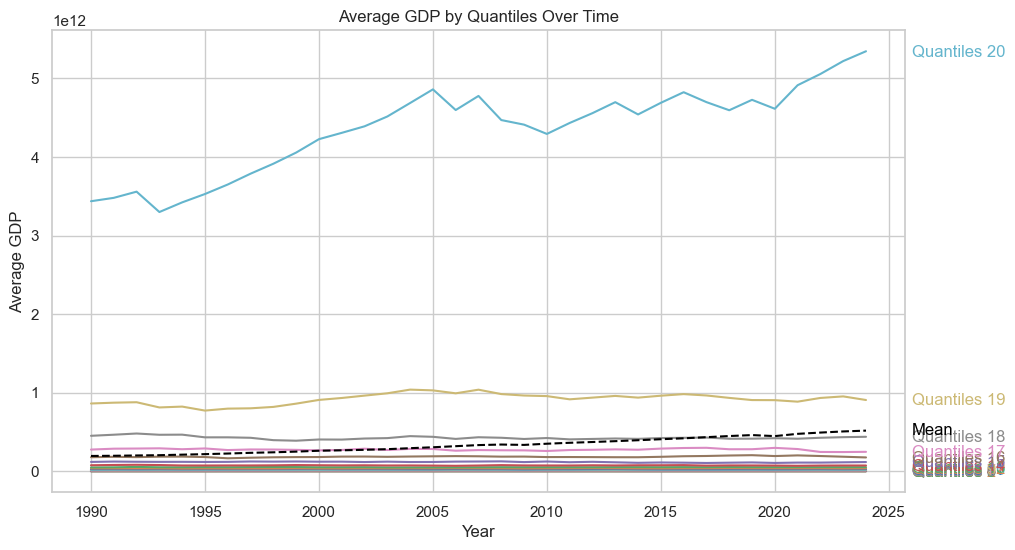

In [47]:
dv.plot_PIB_quantile(PIB_Reel_data_final)


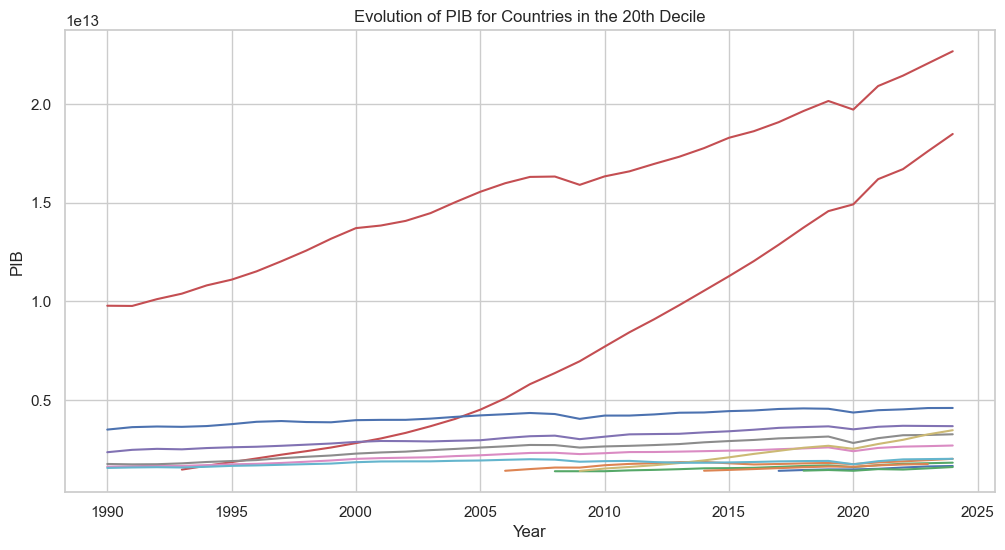

Countries in the 20th-decile: ['AUS' 'BRA' 'CAN' 'CHN' 'DEU' 'ESP' 'FRA' 'GBR' 'IND' 'ITA' 'JPN' 'KOR'
 'RUS' 'USA']


In [48]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final)

Faire un commentaire sur le fait que ce soient les pays les plus développés qui apparaissent dans ce graphique

# Ajout de la variable symbolisant la taille du pays dans l'économie mondiale

In [49]:
dump = PIB_Reel_data_final.groupby(['country','date']).sum().apply(lambda x: 100*x/PIB_Reel_data_final.groupby("date")["PIB"].sum()).reset_index() # Associer à chaque pays son poids dans l'économie mondiale par année
dump.rename(columns={"PIB":"weightCountry"},inplace=True)
weightCountry = dump.groupby(['country']).mean()['weightCountry'].reset_index() 
weightCountry.rename(columns={"weightCountry":"avgWeightCountry"},inplace=True)

weightCountry.sort_values(by="avgWeightCountry",ascending=False)

,country,avgWeightCountry
169,USA,26.409606
31,CHN,10.542865
79,JPN,7.344783
43,DEU,5.376389
56,GBR,4.343731
...,...,...
143,STP,0.000334
102,MHL,0.000311
84,KIR,0.000272
120,NRU,0.000156


# Clustering

On sépare en 4 clusters. Très Bas, Bas, Haut, Très Haut. On fait tourner les kmeans et on remarque les USA sont en tête suivi par la Chine. Ce qui correspond bien à la réalité. Faire d'autre commentaires ensuite.

In [50]:
dv.visualize_economicPower_clusters(weightCountry)


# Temps de reprise des pays après une crise

In [51]:
import pandas as pd
import numpy as np

def peak_to_breach_times(df_country):

    # Ordonner le dataframe pour que les séries temporelles commncent avec des dates croissantes
    df = df_country.sort_values('date').reset_index(drop=True).copy()
    
    df['prev_pib'] = df['PIB'].shift(1)
    df['next_pib'] = df['PIB'].shift(-1)
    df['is_peak'] = (df['PIB'] > df['prev_pib']) & (df['PIB'] > df['next_pib']) # Identifier les pics locaux i.e les années où le PIB est plus élevé que l'année précédente et l'année suivante
    
    peak_indices = df.index[df['is_peak']].tolist()
    
    times = []
    
    for i in peak_indices:
        peak_year = df.loc[i, 'date']
        peak_val = df.loc[i, 'PIB']
        
        # données survenues après le pic
        after_thePeak = df.loc[i+1:].copy()
        if after_thePeak.empty:
            continue
        
        # Si aucune valeur dans la suite n'est inférieure au pic, on continue parce que ça veut dire qu'il n'y a pas eu de crise après ce pic 
        if not (after_thePeak['PIB'] < peak_val).any():

            continue
        
        # Sinon on cherche la première année où le PIB dépasse le pic pour signaler un retour à la normale
        breached = after_thePeak[after_thePeak['PIB'] > peak_val]
        if breached.empty:
            continue
        
        breach_year = breached['date'].iloc[0]
        time_to_breach = breach_year - peak_year
        times.append(time_to_breach)
    
    mean_time = np.mean(times) if len(times) > 0 else np.nan # Permet de calculer un cas moyen
    return mean_time


responseTime_data = pd.DataFrame(PIB_Reel_data_final.groupby('country')[['date','PIB']].apply(lambda x:peak_to_breach_times(x)))
responseTime_data.rename(columns={0:"avgResponseTime"},inplace=True)
responseTime_data.reset_index(inplace=True)
responseTime_data

,country,avgResponseTime
0,AGO,6.000000
1,ALB,2.500000
2,AND,7.333333
3,ARE,3.000000
4,ARG,2.833333
...,...,...
172,VUT,4.000000
173,WSM,3.000000
174,ZAF,2.500000
175,ZMB,2.666667


# Checker des valeurs manquantes

In [52]:
da.check_missing_values(responseTime_data,"avgResponseTime")

Il y a 17 valeurs manquantes sur un total de 177 dans la base de données. Soit un ratio de 9.60% de valeurs manquantes dans la base de données.


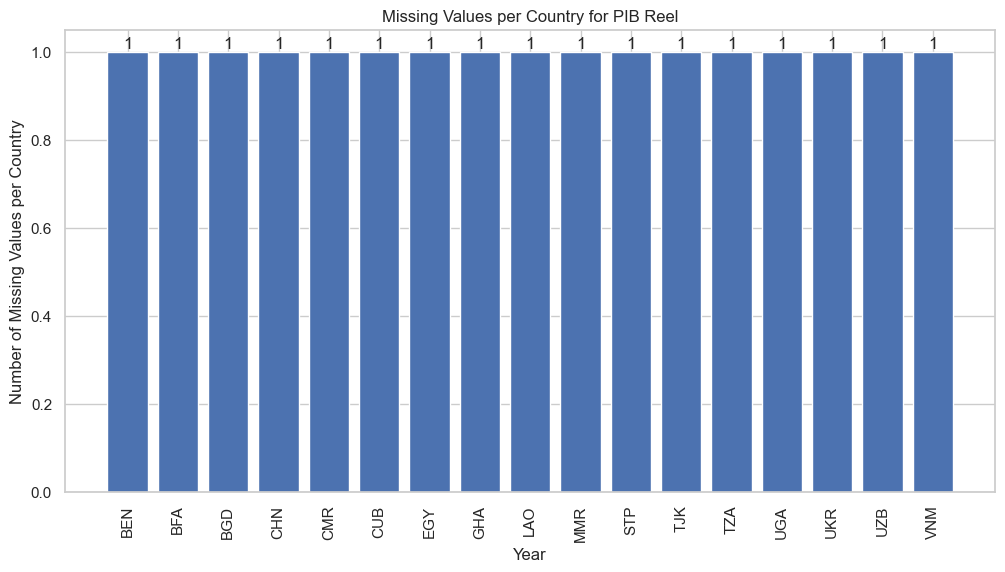

Index(['BEN', 'BFA', 'BGD', 'CHN', 'CMR', 'CUB', 'EGY', 'GHA', 'LAO', 'MMR',
       'STP', 'TJK', 'TZA', 'UGA', 'UKR', 'UZB', 'VNM'],
      dtype='object', name='country')

In [53]:
dv.plot_missing_values_per_country(responseTime_data,"avgResponseTime",treshold=0)

Certains des pays n'ont pas obtenu de temps de réponse avec notre algorithme. On pourrait modéliser en disant qu'ils ont un temps infiniment long ou juste prendre des valeurs arbitrairement grandes. Mais par souci de simplicité et de non penchant à faire des hypothèses fallacieuses, nous allons les sortir de la base de données et réalisés des études sur les pays qui ont un temps de réponse à des scénarios de crises.

In [54]:
responseTime_data.dropna(inplace=True)
responseTime_data.reset_index(drop=True,inplace=True)
responseTime_data

,country,avgResponseTime
0,AGO,6.000000
1,ALB,2.500000
2,AND,7.333333
3,ARE,3.000000
4,ARG,2.833333
...,...,...
155,VUT,4.000000
156,WSM,3.000000
157,ZAF,2.500000
158,ZMB,2.666667


# Importations et exportations

In [55]:
wb = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
importations_data = wb.get_indicator("Importations", liste_pays, start=1990, end=2024)
exportations_data = wb.get_indicator("Exportations", liste_pays, start=1990, end=2024)

# Remplacer les noms des pays par leurs codes ISO dans les deux datasets
importations_data["country"] = importations_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
exportations_data["country"] = exportations_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)

importations_data

,country,date,Importations
0,AFG,2024,NaN
1,AFG,2023,50.731877
2,AFG,2022,54.505427
3,AFG,2021,37.069564
4,AFG,2020,36.289077
...,...,...,...
6750,ZWE,1994,36.519525
6751,ZWE,1993,32.447448
6752,ZWE,1992,36.485231
6753,ZWE,1991,27.168079


In [56]:
exportations_data

,country,date,Exportations
0,AFG,2024,NaN
1,AFG,2023,16.852788
2,AFG,2022,18.380042
3,AFG,2021,14.342153
4,AFG,2020,10.420817
...,...,...,...
6750,ZWE,1994,34.599976
6751,ZWE,1993,30.719617
6752,ZWE,1992,27.227263
6753,ZWE,1991,23.883469


In [57]:
da.check_missing_values(importations_data,"Importations")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 188 pays de 1990 à 2024.
Il y a 1173 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 17.36% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 188 pays de 1990 à 2024.
Il y a 1173 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 17.36% de valeurs manquantes dans la base de données.


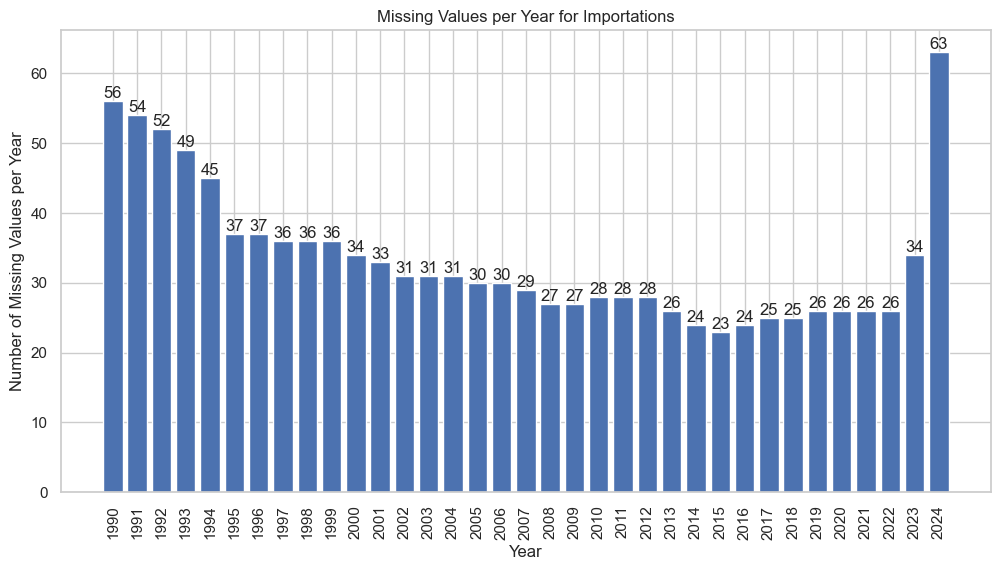

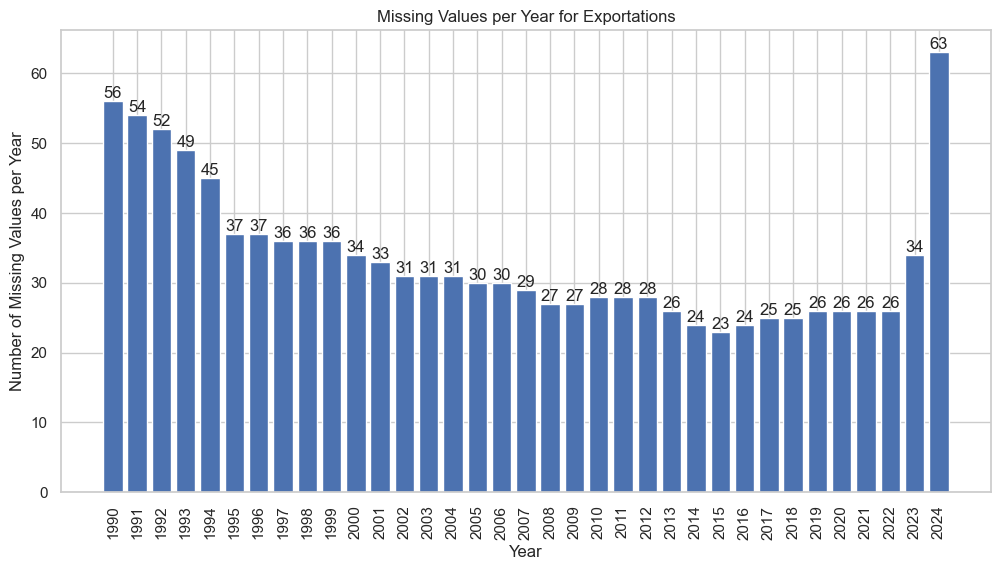

In [58]:
dv.plot_missing_values_per_year(importations_data,"Importations",text="Importations")
dv.plot_missing_values_per_year(exportations_data,"Exportations",text="Exportations")

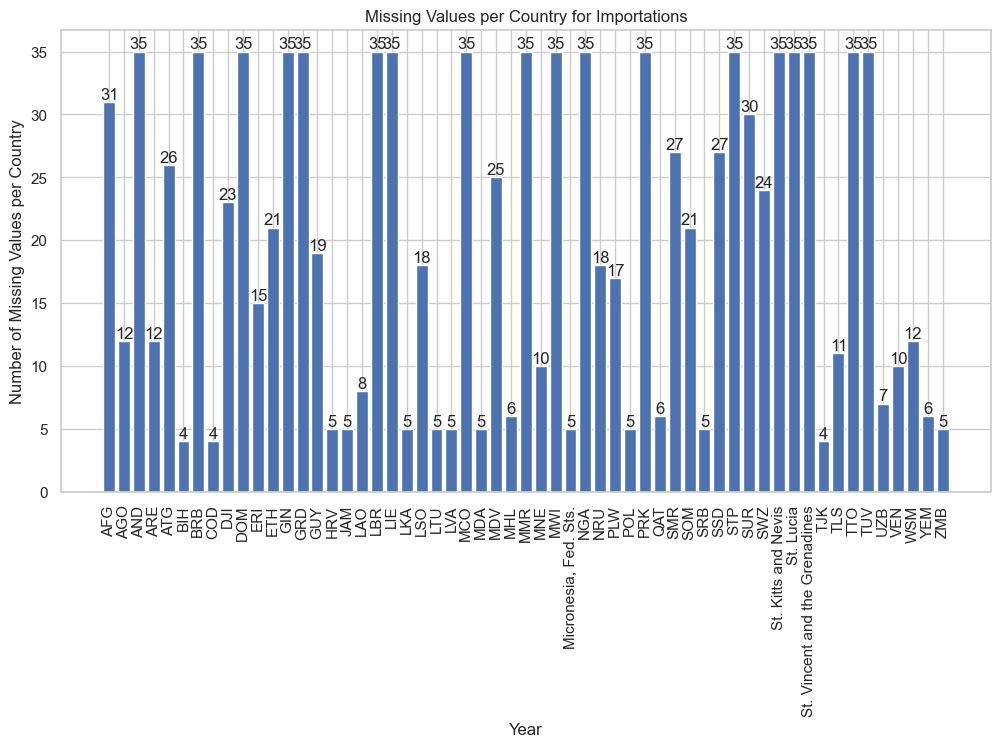

In [59]:
countries_toRemoveImportations = dv.plot_missing_values_per_country(importations_data,"Importations",treshold=0.1,text="Importations")

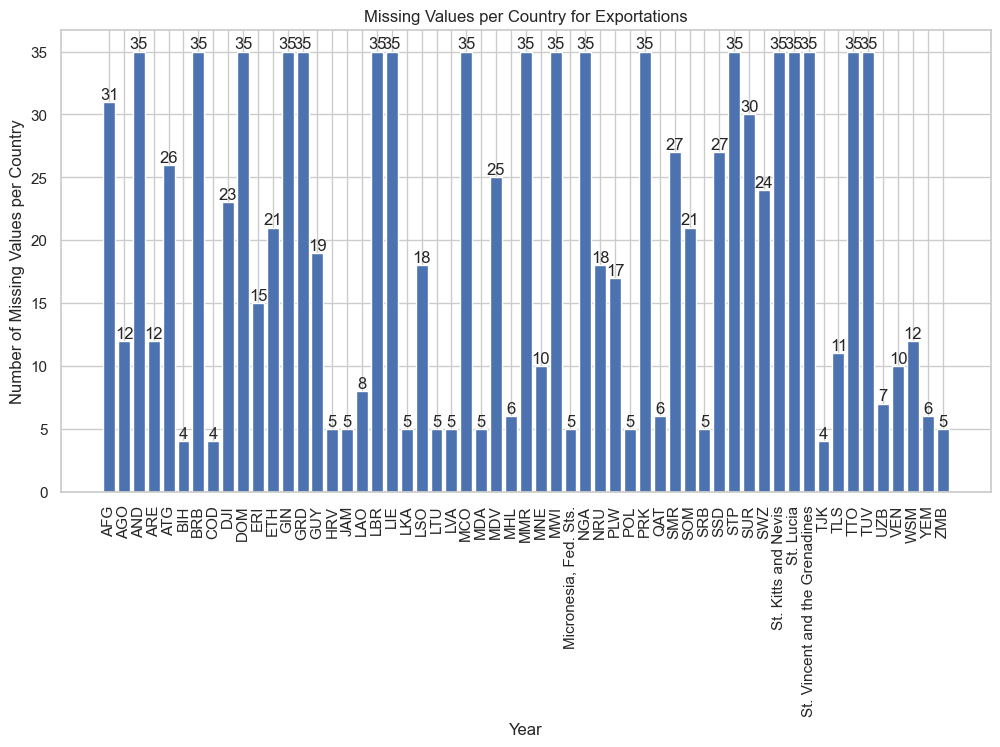

In [60]:
countries_toRemoveExportations = dv.plot_missing_values_per_country(exportations_data,"Exportations",treshold=0.1,text="Exportations")

In [61]:
indexes_toRemoveImports = []
indexes_toRemoveExports = []

for country in countries_toRemoveImportations:
    country_indexes = importations_data[importations_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

for country in countries_toRemoveExportations:
    country_indexes = exportations_data[exportations_data["country"]==country].index.tolist()
    indexes_toRemoveExports.extend(country_indexes)

In [62]:
importations_data
da.check_missing_values(importations_data,"Importations")

importations_data = importations_data.drop(indexes_toRemove,axis='index')
importations_data.reset_index(drop=True,inplace=True)
da.check_missing_values(importations_data,"Importations")

Le dataframe contient des données temporelles relatives à 188 pays de 1990 à 2024.
Il y a 1173 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 17.36% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 39 valeurs manquantes sur un total de 4585 dans la base de données. Soit un ratio de 0.85% de valeurs manquantes dans la base de données.


In [64]:
exportations_data
da.check_missing_values(exportations_data,"Exportations")

exportations_data = exportations_data.drop(indexes_toRemove,axis='index')
exportations_data.reset_index(drop=True,inplace=True)
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 188 pays de 1990 à 2024.
Il y a 1173 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 17.36% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 39 valeurs manquantes sur un total de 4585 dans la base de données. Soit un ratio de 0.85% de valeurs manquantes dans la base de données.


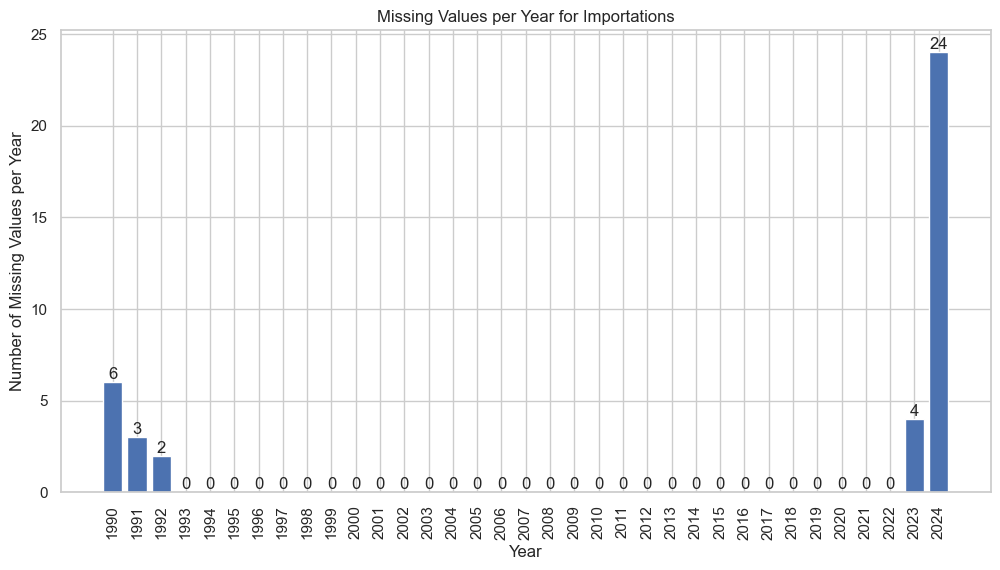

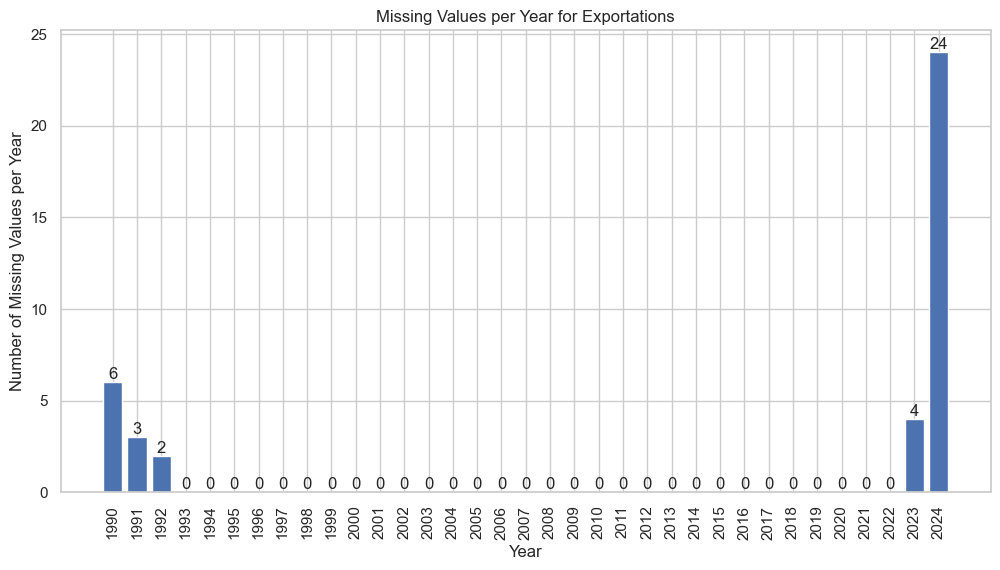

In [65]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(importations_data,"Importations",text="Importations")
dv.plot_missing_values_per_year(exportations_data,"Exportations",text="Exportations")

In [ ]:
# # La majeure partie des valeurs manquantes sont en 2024. On peut les imputer avec la moyenne des années précédentes.
# PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
# da.check_missing_values(PIB_Reel_data_final,"PIB")
# PIB_Reel_data_final

# importations_data